In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrow

# ========== 基础设置 ==========
grid_size = 1.0
nx, ny = 20, 20
circle_center = np.array([10.0, 10.0])
circle_radius = 5.2
num_circle_points = 5

# ========== 创建圆形边界（离散点） ==========
theta = np.linspace(0, 2 * np.pi, num_circle_points)
circle_points = np.stack([
    circle_center[0] + circle_radius * np.cos(theta),
    circle_center[1] + circle_radius * np.sin(theta)
], axis=1)


In [14]:

# ========== Crossing Number Test ==========
def crossing_number(p, polygon):
    cn = 0
    n = len(polygon)
    for i in range(n):
        v1, v2 = polygon[i], polygon[(i + 1) % n]
        if ((v1[1] <= p[1] and v2[1] > p[1]) or
            (v1[1] > p[1] and v2[1] <= p[1])):
            vt = (p[1] - v1[1]) / (v2[1] - v1[1])
            if np.abs(v2[1] - v1[1]) < 1e-12:
                continue
            ixc = v1[0] + vt * (v2[0] - v1[0])
            if p[0] < ixc:
                cn += 1
    return cn % 2 == 1

# ========== 找交点（沿方向射线） ==========
def find_intersection(p, direction, polygon):
    hits = []
    n = len(polygon)
    for i in range(n):
        a = polygon[i]
        b = polygon[(i + 1) % n]
        ab = b - a
        denom = ab[0] * direction[1] - ab[1] * direction[0]
        if np.abs(denom) < 1e-12:
            continue
        t = ((p[0] - a[0]) * direction[1] - (p[1] - a[1]) * direction[0]) / denom
        u = ((a[0] - p[0]) * ab[1] - (a[1] - p[1]) * ab[0]) / -denom
        if 0 <= t <= 1 and u > 0:
            inter = a + t * ab
            hits.append((u, inter))
    if hits:
        hits.sort(key=lambda x: x[0])
        return hits[0][1]
    return None


In [15]:
# ========== 遍历所有 cell，查找 cut-cell ==========
cut_faces = []

for i in range(nx):
    for j in range(ny):
        x0 = i * grid_size
        y0 = j * grid_size
        cell_corners = np.array([
            [x0, y0],
            [x0 + grid_size, y0],
            [x0 + grid_size, y0 + grid_size],
            [x0, y0 + grid_size]
        ])
        in_flags = [crossing_number(p, circle_points) for p in cell_corners]

        if not any(in_flags):
            continue  # 全在 fluid 区域，不处理

        # 查找从 solid 点出发的交点
        intersections = []
        for p, inside in zip(cell_corners, in_flags):
            if not inside:
                continue
            for direction in [np.array([1,0]), np.array([-1,0]), np.array([0,1]), np.array([0,-1])]:
                inter = find_intersection(p, direction, circle_points)
                if inter is not None:
                    # 只保留落在 cell 边界上的交点
                    if (x0 - 1e-6 <= inter[0] <= x0 + grid_size + 1e-6 and
                        y0 - 1e-6 <= inter[1] <= y0 + grid_size + 1e-6):
                        intersections.append(inter)

        # 如果找到两个交点，构造线段
        if len(intersections) == 2:
            p0, p1 = intersections
            normal = np.array([p1[1] - p0[1], -(p1[0] - p0[0])])
            normal /= np.linalg.norm(normal)
            mid = 0.5 * (p0 + p1) + normal * 0.5
            inside = crossing_number(mid, circle_points)
            if inside:
                normal = -normal
            cut_faces.append((p0, p1, normal))


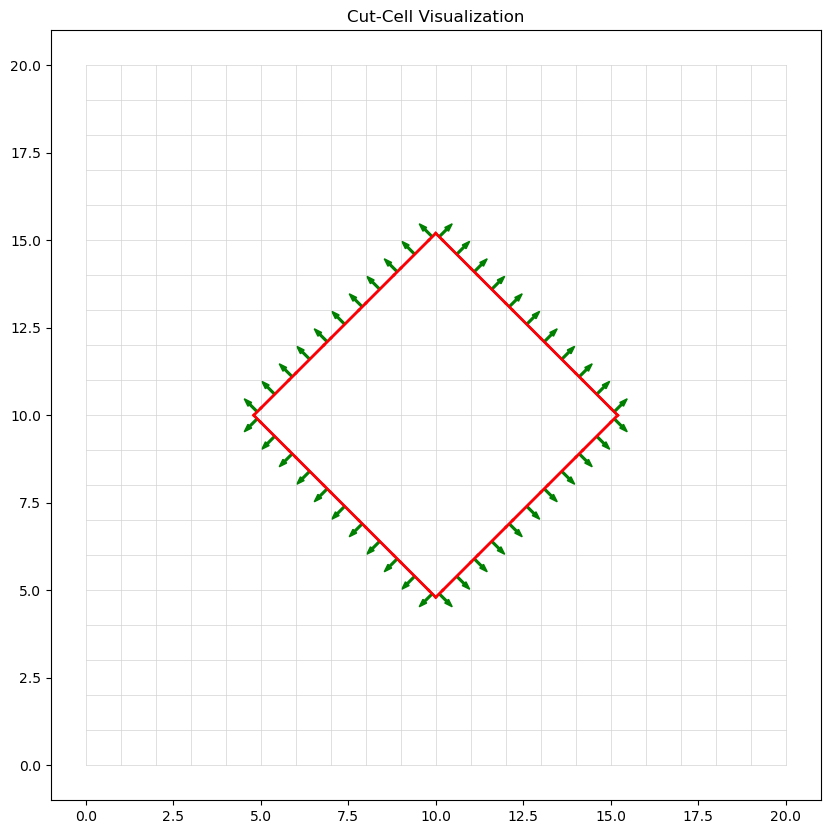

In [16]:
# ========== 可视化 ==========
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')
ax.set_title("Cut-Cell Visualization")

# 网格线
for i in range(nx + 1):
    ax.plot([i * grid_size, i * grid_size], [0, ny * grid_size], color='lightgray', lw=0.5)
for j in range(ny + 1):
    ax.plot([0, nx * grid_size], [j * grid_size, j * grid_size], color='lightgray', lw=0.5)

# 圆形边界
ax.plot(circle_points[:,0], circle_points[:,1], 'b')

# cut faces
for p0, p1, n in cut_faces:
    ax.plot([p0[0], p1[0]], [p0[1], p1[1]], 'r-', lw=2)
    mid = 0.5 * (p0 + p1)
    ax.add_patch(FancyArrow(mid[0], mid[1], 0.3 * n[0], 0.3 * n[1],
                            width=0.05, color='green'))

plt.xlim(-1, (nx + 1) * grid_size)
plt.ylim(-1, (ny + 1) * grid_size)
plt.grid(False)
plt.show()